# Title : Image Processing Using Traditional Machine Learning

### ---------------------------------------------------------------------------------------------------------------------------------

##### Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob       
import cv2
from sklearn import preprocessing
from skimage.filters import sobel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

##### Image Pre-processing - 
##### Reading images, resizng images to fixed size (32*32) and Gray-scaling

In [2]:
size=32

train_images=[]
train_labels=[]
for directory_path in glob.glob("C:/Users/nihal/Desktop/Python/Yoga Pose Image Classification/TRAIN/*"):
    #splitting subfolders names within train folder and taking it as label
    label=directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) #open image in black and white
        img=cv2.resize(img,(size,size)) #resize images
        
        train_images.append(img)
        train_labels.append(label)
        
#converting lists into numpy arrays      
train_images=np.array(train_images)
train_labels=np.array(train_labels)

downdog
goddess
plank
tree
warrior2


In [19]:
print(train_images[0])

[[241 242 244 ... 250 249 249]
 [241 241 242 ... 250 249 248]
 [240 241 242 ... 250 249 247]
 ...
 [232 232 234 ... 245 246 246]
 [234 234 235 ... 248 249 249]
 [234 235 235 ... 250 250 251]]


The output above prints the labels of the yoga poses i.e., 5 classes for classification.

In [3]:
test_images=[]
test_labels=[]
for directory_path in glob.glob("C:/Users/nihal/Desktop/Python/Yoga Pose Image Classification/TEST/*"):
    label=directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        
        img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(size,size))
        
        test_images.append(img)
        test_labels.append(label)
        
test_images=np.array(test_images)
test_labels=np.array(test_labels)

##### Image Pre-processing - Lable encoding and Normalization

In [4]:
# Encode labels to integer

le=preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded=le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)
print(np.unique(train_labels_encoded))

[0 1 2 3 4]


The yoga poses are encoded as follows :
class0 - downdog,
class1 - goddess,
class2 - plank,
class3 - tree,
class4 - warrior2.

In [5]:
# Assign dependent and independent variables
x_train,x_test,y_train,y_test=train_images,test_images,train_labels_encoded,test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train,x_test=x_train/255.0,x_test/255.0

In [6]:
print(x_train.shape)
print(x_test.shape)

(1001, 32, 32)
(428, 32, 32)


##### Feature extraction using Gabor filters and  edge detection using Sobel Kernels

In [7]:
def feature_extractor(dataset):
    image_dataset=pd.DataFrame()
    for image in range(dataset.shape[0]):
        df=pd.DataFrame()
        img=dataset[image,:,:]
        pixel_values=img.reshape(-1)
        df['pixel_value']=pixel_values
        num=1
        kernels=[]
        
        for theta in range(2):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)  
                #Label Gabor columns as Gabor1, Gabor2, etc.
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda,
                                            gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)   #cv2.CV_8UC3 - 8 bit unsigned integer
                filtered_img = fimg.reshape(-1)
                
                #Labels columns as Gabor1, Gabor2, etc.
                df[gabor_label] = filtered_img  
                #print(gabor_label, ': theta=', theta, ': sigma=', 
                #      sigma, ': lamda=', lamda, ': gamma=', gamma)
                
                #Increment for gabor column label
                num += 1         
                
        #Sobel kernel    
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
    return image_dataset

In [8]:
#Extract features from training images
image_features = feature_extractor(x_train)

#Reshape to a vector for training models
image_features = np.expand_dims(image_features, axis=0)
X_train = np.reshape(image_features, (x_train.shape[0], -1)) 

#Extract features from testing images
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
X_test = np.reshape(test_features, (x_test.shape[0], -1))

In [9]:
print(X_train.shape)
print(X_test.shape)

(1001, 6144)
(428, 6144)


###### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Model Building 
##### 1. K-Nearest Neighbor

In [10]:
knn=KNeighborsClassifier(metric='manhattan',n_neighbors=4)
print(knn.fit(X_train,y_train))
#print(knn.score(X_train,y_train))
y_pred=knn.predict(X_test)
acc_knn=metrics.accuracy_score(y_test,y_pred)
print("Testing accuracy of knn model is ",acc_knn)

KNeighborsClassifier(metric='manhattan', n_neighbors=4)
Testing accuracy of knn model is  0.5584112149532711


Performance Measure of knn model:

               precision    recall  f1-score   support

           0       0.59      0.67      0.63        91
           1       0.36      0.46      0.41        70
           2       0.69      0.58      0.63       103
           3       0.59      0.66      0.62        65
           4       0.56      0.43      0.49        99

    accuracy                           0.56       428
   macro avg       0.56      0.56      0.56       428
weighted avg       0.57      0.56      0.56       428



Text(0.5, 1.0, 'Confusion matrix')

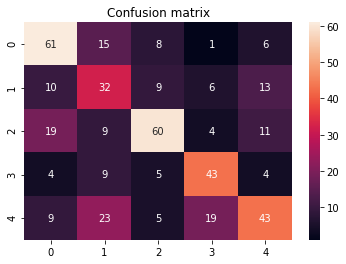

In [11]:
print("Performance Measure of knn model:\n\n",metrics.classification_report(y_test, y_pred))
confusion_knn=metrics.confusion_matrix(y_true=y_test,y_pred=y_pred)
s=sns.heatmap(confusion_knn,annot=True)
s.set_title("Confusion matrix")

KNN algorithm performs moderately giving overall accuracy 55.8%. But it misclassifies the poses in class4 (warrior pose) as class1 (goddess pose).

##### 2. Naive Bayes Classifier

In [12]:
gnb = GaussianNB(var_smoothing=0.00005)
print(gnb.fit(X_train, y_train))
y_pred=gnb.predict(X_test)
acc_nb=metrics.accuracy_score(y_test,y_pred)
print("Testing accuracy of Naive Bayes model is ",acc_nb)

GaussianNB(var_smoothing=5e-05)
Testing accuracy of Naive Bayes model is  0.3294392523364486


Performance Measure of Naive Bayes model:

               precision    recall  f1-score   support

           0       0.38      0.23      0.29        91
           1       0.45      0.27      0.34        70
           2       0.61      0.29      0.39       103
           3       0.22      0.88      0.35        65
           4       0.58      0.14      0.23        99

    accuracy                           0.33       428
   macro avg       0.45      0.36      0.32       428
weighted avg       0.47      0.33      0.32       428



Text(0.5, 1.0, 'Confusion matrix')

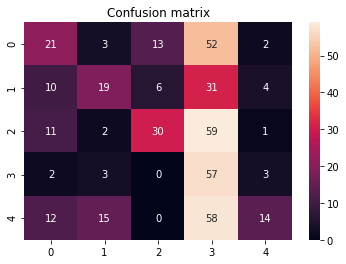

In [13]:
print("Performance Measure of Naive Bayes model:\n\n",metrics.classification_report(y_test, y_pred))
confusion_NB=metrics.confusion_matrix(y_true=y_test,y_pred=y_pred)

s=sns.heatmap(confusion_NB,annot=True)
s.set_title("Confusion matrix")

Naive Bayes Classifier perform poorly with accuracy 33%. Majority of the poses are misclassified into class3 (plank).

##### 3. Random Forest

In [14]:
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 11,
                                  max_depth = 7,
                                  min_samples_leaf= 20
                                  )
print(RF_model.fit(X_train, y_train))
y_pred=RF_model.predict(X_test)
acc_rf=metrics.accuracy_score(y_test,y_pred)
print("Testing accuracy of Random Forest model is ",acc_rf)

RandomForestClassifier(max_depth=7, min_samples_leaf=20, random_state=11)
Testing accuracy of Random Forest model is  0.7102803738317757


Performance Measure of Random Forest model:

               precision    recall  f1-score   support

           0       0.83      0.58      0.68        91
           1       0.83      0.27      0.41        70
           2       0.72      0.88      0.79       103
           3       1.00      0.77      0.87        65
           4       0.55      0.92      0.69        99

    accuracy                           0.71       428
   macro avg       0.79      0.69      0.69       428
weighted avg       0.76      0.71      0.69       428



Text(0.5, 1.0, 'Confusion matrix')

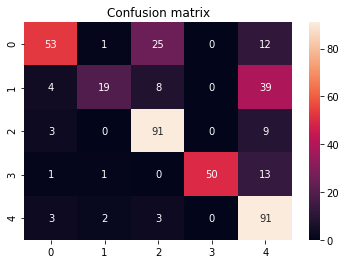

In [15]:
print("Performance Measure of Random Forest model:\n\n",metrics.classification_report(y_test, y_pred))
confusion_rf=metrics.confusion_matrix(y_true=y_test,y_pred=y_pred)

s=sns.heatmap(confusion_rf,annot=True)
s.set_title("Confusion matrix")

The random forest classifier performs well giving overall accuracy 71%. It stuggles to classify the poses in class1 (goddess pose) giving 39 misclassifications in class4 (warrior pose).

##### 4. Support Vector Machine

In [16]:
svm_clf = svm.SVC(kernel = 'rbf', gamma = 0.00008, C = 1,
              decision_function_shape= 'ovr', 
              random_state = 0)

print(svm_clf.fit(X_train, y_train))
y_pred=svm_clf.predict(X_test)
acc_svm=metrics.accuracy_score(y_test,y_pred)
print("Testing accuracy of SVM model is ",acc_svm)


SVC(C=1, gamma=8e-05, random_state=0)
Testing accuracy of SVM model is  0.6799065420560748


Performance Measure of SVM model:

               precision    recall  f1-score   support

           0       0.75      0.71      0.73        91
           1       0.74      0.24      0.37        70
           2       0.75      0.79      0.77       103
           3       0.88      0.69      0.78        65
           4       0.52      0.84      0.64        99

    accuracy                           0.68       428
   macro avg       0.73      0.65      0.66       428
weighted avg       0.71      0.68      0.67       428



Text(0.5, 1.0, 'Confusion matrix')

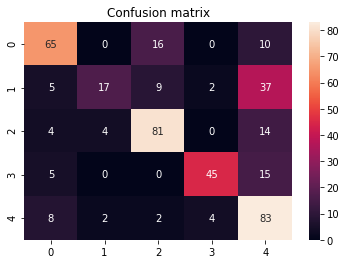

In [17]:
print("Performance Measure of SVM model:\n\n",metrics.classification_report(y_test, y_pred))
confusion_svm=metrics.confusion_matrix(y_true=y_test,y_pred=y_pred)

s=sns.heatmap(confusion_svm,annot=True)
s.set_title("Confusion matrix")

The SVM model with non-linear kernel RBF performs well giving accuracy 68%. The misclassification problem in class1 and class4 still exists. 

### ---------------------------------------------------------------------------------------------------------------------------------

##### Comparison between all ML classifiers

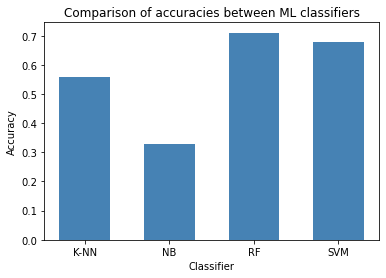

In [18]:
acc=[acc_knn,acc_nb,acc_rf,acc_svm]
models=['K-NN','NB','RF','SVM']
plt.bar(models,acc,width=0.6,color='steelblue')
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of accuracies between ML classifiers")
plt.show()

Random Forest performs best with the accuracy 71%.